# Free Spoken Digit classification

In this exercise you will build a complete data analytics pipeline to pre-process your audio signals and build a classification model able to distinguish between the classes available in the dataset.

More specifically, you will load, analyze and prepare the Free Spoken Digit dataset to train and validate a classification model.

# Analyzing the dataset

## 1. Load the dataset from the root folder 

### Dataset organization
The dataset archive is organized as follows:
- dev: the folder that contains the labeled recordings;
- eval: the folder that contains the unlabeled recordings. Use this data to produce the submission file
containing the predicted labels.

In [1]:
from os import listdir
from os.path import join

root_folder : str   = 'dataset'
dev         : str   = 'development'
eval        : str   = 'evaluation'

dev_files   : list[str] = listdir(join(root_folder, dev))
eval_files  : list[str] = listdir(join(root_folder, eval))

print(f'Development .wav file names: {dev_files[:5]}')
print(f'Evaluation .wav file names: {eval_files[:5]}')

Development .wav file names: ['0_4.wav', '1000_0.wav', '1001_1.wav', '1002_6.wav', '1003_2.wav']
Evaluation .wav file names: ['0.wav', '1.wav', '10.wav', '100.wav', '101.wav']


### Converting the Data set into an usefull format

Create a data frame for storing all the information of the recordings

In [2]:
from scipy.io.wavfile import read as read_wav # read .wav files

def convert_files_for_df(file_list : list[str], options : str = 'dev') -> list[dict]:
    """Convert element of the given list to the proper format

    Args:
        file_list (list[str]): Input list to be converted
        options (str, optional): Information on how to the input strings are formatted:
            - 'dev' (default) => format is '<idx>_<label>.wav'
            - 'eval' => format is '<idx>.wav'

    Returns:
        converted_data (list[dict]): each converted element is in a separate dict
    """
    splitted : list[list[str]] = [element.replace('.', '_').split('_')[:-1] for element in file_list]
    
    if options == 'eval':
        return [{'idx' : int(input_str[0]), 'full_path': join(root_folder, eval, file_list[i]), 'wav_data' : read_wav(join(root_folder, eval, file_list[i]))} for i, input_str in enumerate(splitted)]
    else: # default
        return [{'idx' : int(col[0]), 'label' : int(col[1]), 'full_path' : join(root_folder, dev, file_list[i]), 'wav_data' : read_wav(join(root_folder, dev, file_list[i]))} for i, col in enumerate(splitted)]

In [3]:
#  Convert the development dataset in a pandas data frame, with index 'idx' and columns ['label', 'full_path', 'wav_data']
import pandas as pd # create data frame

dev_dataset : pd.DataFrame = pd.DataFrame(data = convert_files_for_df(dev_files)).set_index('idx').sort_index()

print(dev_dataset.head(5))
print('\nDataset information:')
print(dev_dataset.info())

     label                    full_path  \
idx                                       
0        4  dataset\development\0_4.wav   
1        7  dataset\development\1_7.wav   
2        5  dataset\development\2_5.wav   
3        2  dataset\development\3_2.wav   
4        3  dataset\development\4_3.wav   

                                              wav_data  
idx                                                     
0    (8000, [14, 21, 0, 18, -11, 22, -15, -53, 9, -...  
1    (8000, [-2, 12, 1, -18, 7, -7, 1, -1, 0, 0, -6...  
2    (8000, [-9, -7, -5, -8, -13, -1, 20, -12, 6, 1...  
3    (8000, [-256, -512, 0, -256, 256, -256, 0, -51...  
4    (8000, [-20, 10, 26, -13, 22, -16, 11, 7, -21,...  

Dataset information:
<class 'pandas.core.frame.DataFrame'>
Index: 1500 entries, 0 to 1499
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      1500 non-null   int64 
 1   full_path  1500 non-null   object
 2   wav_data   1500

## 2. Analyze the wav_data column

### Visualize waveform

Let us analyze what the wav_data column contains, using the first element of the data frame as an example

In [43]:
test_element : pd.Series = dev_dataset.iloc[1422]
print(test_element)

label                                                        0
full_path                       dataset\development\1422_0.wav
wav_data     (8000, [-304, -319, -377, -432, -484, -556, -6...
Name: 1422, dtype: object


Each wav file return a sample rate and a data array

In [44]:
sample_rate, data = test_element['wav_data']

print(f'Sample rate = {sample_rate}')
print(f'Data shape: {data.shape}, Data type (audio resolution): {data.dtype}')

Sample rate = 8000
Data shape: (5165,), Data type (audio resolution): int16


data.shape is and 1-D array, meaning that we only have 1 audio channel. With the length of the array and the sample rate, we can also calculate the duration of the audio recording

In [45]:
time_length : float =  data.shape[0] / sample_rate
print(f'Duration of the audio recording = {time_length} seconds')

Duration of the audio recording = 0.645625 seconds


We can also visualize the waveform with a plot

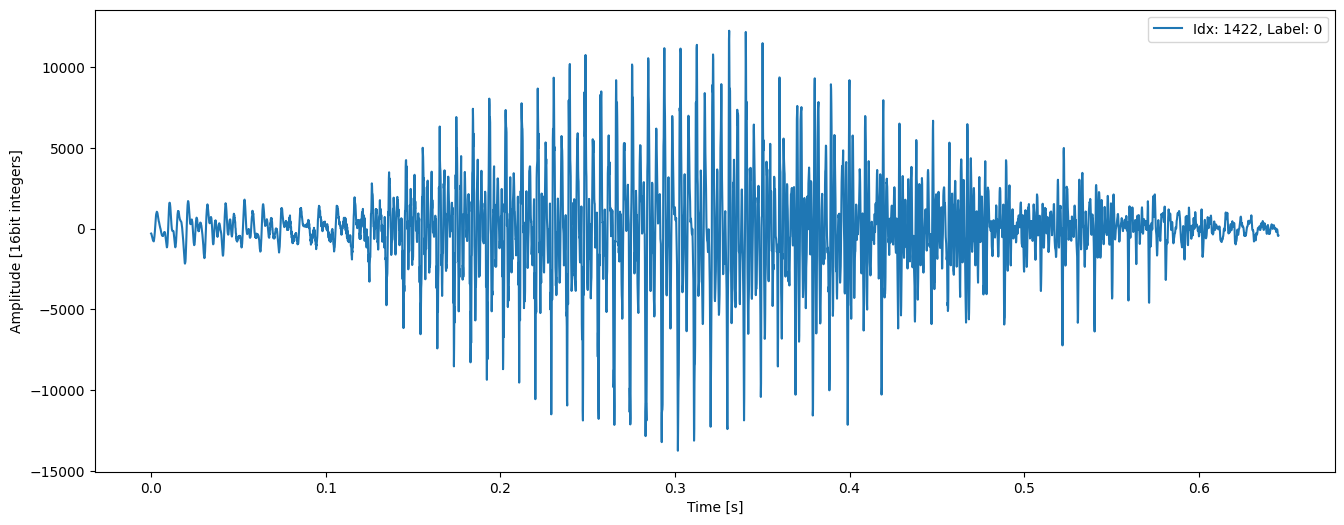

In [46]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize = (16, 6)) # create figure

time_axis = np.linspace(0.0, time_length, data.shape[0]) # create x axis
ax.plot(time_axis, data, label = f'Idx: {test_element.name}, Label: {test_element['label']}') # plot
ax.set_xlabel(xlabel = 'Time [s]')
ax.set_ylabel(ylabel = 'Amplitude [16bit integers]')
ax.legend()

plt.show()

### Normalize waveform

Since many audio files have different volume level and different length, to be able to compere them it's necessary to perform some tranformation.

A first operation might be an audio signal normalization, so in the future we will be able to define variables and constraint that will be in common for all the files.

In [123]:
import numpy as np

def normalize_audio(audio_data, samplerate = 8000, target_level=1.0):
    """Normalizes audio data.

    Args:
      audio_data: The audio data as a numpy array.
      samplerate: The sample rate of the audio.
      target_level: The target level for normalization.

    Returns:
      A numpy array containing the normalized audio data.
    """

    # Peak normalization
    peak = np.max(np.abs(audio_data))
    normalized_data = audio_data * (target_level / peak)

    return normalized_data

Let's test the function on the test data

In [ ]:
peak_test = normalize_audio(data, sample_rate, target_level = 10.0)

print(f'Normalized shape {peak_test.shape}; Normalized Data Type {peak_test.dtype}')

Normalized shape (5165,); Normalized Data Type float64


array([-308.76406639, -323.99913545, -382.90806917, ..., -444.8640167 ,
       -464.16177085, -431.66029018])

Let's then compare the original and the normalized signal

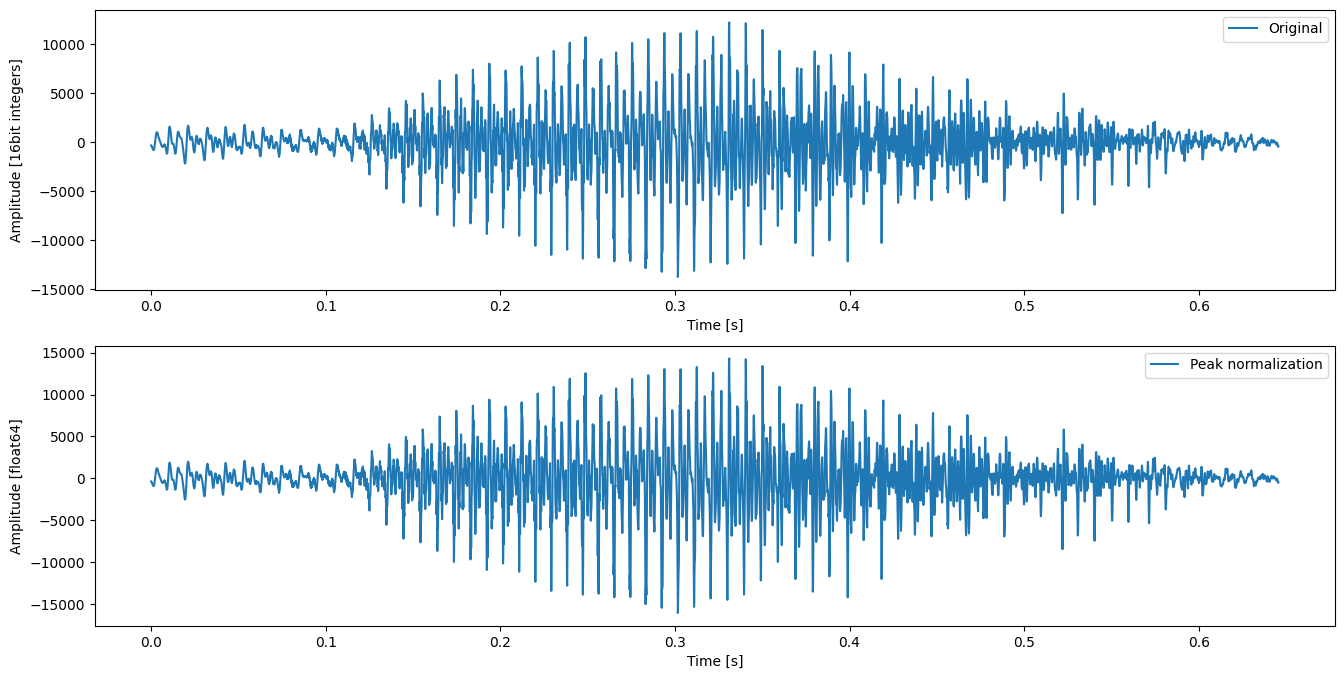

In [137]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (16, 8)) # create figure

time_axis = np.linspace(0.0, time_length, data.shape[0]) # common for both signals

ax[0].plot(time_axis, data, label = 'Original')
ax[0].set_xlabel(xlabel = 'Time [s]')
ax[0].set_ylabel(ylabel = 'Amplitude [16bit integers]')
ax[0].legend()

ax[1].plot(time_axis, rms_test, label = 'Peak normalization')
ax[1].set_xlabel(xlabel = 'Time [s]')
ax[1].set_ylabel(ylabel = 'Amplitude [float64]')
ax[1].legend()

plt.show()